### Does CellariumGPT recapitulate empirical mean for a given cell type?

In [2]:
import os
import torch
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))

DEVICE = torch.device('cuda:0')

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext, \
    GeneNetworkAnalysisBase

In [ ]:
ROOT_PATH = "/home/mehrtash/data"

PREFIX_LIST = [
    "10M_001_bs1536",
    "19M_001_bs2048",
    "30M_001_bs2560",
    "100M_long_run_last"
]

CHECKPOINT_PATH_LIST = [
    "/home/mehrtash/data/mb_checkpoints/10M_001_bs1536/epoch=1-step=29161__updated.ckpt",
    "/home/mehrtash/data/mb_checkpoints/19M_001_bs2048/epoch=1-step=28244__updated.ckpt",
    "/home/mehrtash/data/mb_checkpoints/30M_001_bs2560/epoch=2-step=43129__updated.ckpt",
    "/home/mehrtash/data/100M_long_run/run_001/lightning_logs/version_3/checkpoints/epoch=5-step=504000.ckpt"
]

REF_ADATA_PATH = os.path.join(ROOT_PATH, "data", "extract_0.h5ad")
GENE_INFO_PATH = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")

In [43]:
# load validation cell type table
val_adata = sc.read_h5ad(
    os.path.join(ROOT_PATH, "data", "cellariumgpt_artifacts", "cell_types_for_validation_filtered.h5ad"))

In [5]:
val_adata

AnnData object with n_obs × n_vars = 61 × 28680
    obs: 'cell_type', 'assay', 'suspension_type', 'tissue', 'sex', 'disease', 'total_mrna_umis'
    var: 'feature_id', 'feature_name'

In [6]:
# show the full dataframe
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(val_adata.obs)

,cell_type,assay,suspension_type,tissue,sex,disease,total_mrna_umis
0,GABAergic neuron,10x 3' v3,nucleus,brain,male,normal,5527.708887
1,glutamatergic neuron,10x 3' v3,nucleus,brain,male,normal,10683.399862
2,astrocyte,10x 3' v3,nucleus,brain,male,normal,5380.963698
3,oligodendrocyte,10x 3' v3,nucleus,brain,male,normal,5083.603161
4,oligodendrocyte precursor cell,10x 3' v3,nucleus,brain,male,normal,6609.696174
5,microglial cell,10x 3' v3,nucleus,brain,male,normal,3645.962305
6,cerebellar granule cell,10x 3' v3,nucleus,brain,male,normal,3935.779702
7,endothelial cell,10x 3' v3,nucleus,brain,male,normal,3115.828938
8,classical monocyte,10x 5' v2,cell,blood,male,normal,3922.025000
9,non-classical monocyte,10x 5' v2,cell,blood,male,normal,8436.318182


In [7]:
query_gene_ids = val_adata.var['feature_id'].values
query_gene_symbols = val_adata.var['feature_name'].values

In [11]:
from tqdm.auto import tqdm

model_X_kng = np.zeros((
    len(PREFIX_LIST),
    len(val_adata),
    len(query_gene_ids)))

for k in tqdm(range(len(PREFIX_LIST))):

    prefix = PREFIX_LIST[k]
    checkpoint_path = CHECKPOINT_PATH_LIST[k]

    ctx = CellariumGPTInferenceContext(
        cellarium_gpt_ckpt_path=checkpoint_path,
        ref_adata_path=REF_ADATA_PATH,
        gene_info_tsv_path=GENE_INFO_PATH,
        device=DEVICE,
        attention_backend="mem_efficient",
        verbose=False
    )

    for n in tqdm(range(len(val_adata))):

        # arguments
        row = val_adata.obs.iloc[n]

        assay = row.assay
        suspension_type = row.suspension_type
        prompt_metadata_dict = {
            "cell_type": row.cell_type,
            "tissue": row.tissue,
            "disease": row.disease,
            "sex": row.sex,
        }
        total_mrna_umis = float(row.total_mrna_umis)

        query_chunk_size = 1_000
        max_counts = 500
        upper_percentile = 0.5  # doesn't matter, we only need the logits
        upper_pad = 1  # doesn't matter, we only need the logits

        gex_range_dict = ctx.predict_gene_expression_range_for_metadata(
            assay=assay,
            suspension_type=suspension_type,
            prompt_metadata_dict=prompt_metadata_dict,
            total_mrna_umis=total_mrna_umis,
            query_gene_ids=query_gene_ids,
            query_chunk_size=query_chunk_size,
            total_prob_mass=upper_percentile,
            symmetric_range_pad=upper_pad,
            max_counts=max_counts,
        )

        model_X_kng[k, n, :] = gex_range_dict['gene_marginal_mean_q'].cpu().numpy()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/29 [00:00<?, ?it/s]

In [12]:
# renormalize
model_X_kng = 10_000 * model_X_kng / model_X_kng.sum(axis=-1, keepdims=True)
empirical_X_ng = val_adata.X.copy()
empirical_X_ng = 10_000 * empirical_X_ng / empirical_X_ng.sum(axis=1, keepdims=True)

In [25]:
from collections import defaultdict

results_dict = defaultdict(list)

for k in range(len(PREFIX_LIST)):
    for n in range(len(val_adata)):
        x = np.log1p(empirical_X_ng[n, :])
        y = np.log1p(model_X_kng[k, n, :])
        r_squared = np.corrcoef(x, y)[0, 1] ** 2

        results_dict['val_cell_type_idx'].append(n)
        results_dict['prefix'].append(PREFIX_LIST[k])
        results_dict[f'r_squared'].append(r_squared)

In [27]:
df = pd.DataFrame(results_dict)

Text(0, 0.5, 'R²')

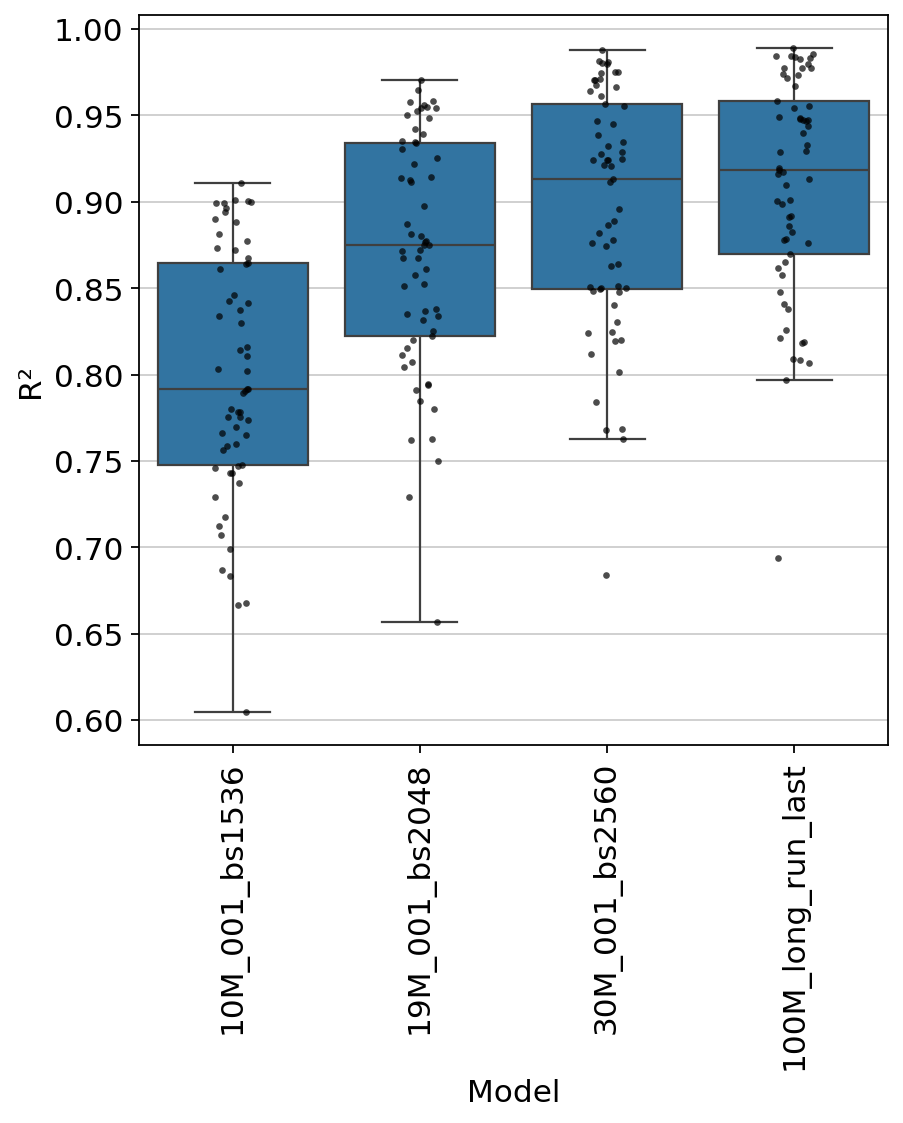

In [35]:
import seaborn as sns

# Create the plot with boxplot and jittered points.
plt.figure(figsize=(6, 6))

# Plot the boxplot without outliers.
ax = sns.boxplot(
    x='prefix',
    y='r_squared',
    data=df,
    order=PREFIX_LIST,       # enforce prefix order
    showfliers=False,        # do not show outliers
    linewidth=1            # thinner lines
)

# Overlay the actual points with jitter.
sns.stripplot(
    x='prefix',
    y='r_squared',
    data=df,
    order=PREFIX_LIST,
    dodge=True,    # position points within each box category
    jitter=True,   # add jitter for better visibility
    marker='o',
    color='black',
    alpha=0.7,
    size=3
)

plt.xticks(rotation=90)

ax.set_xlabel('Model')
ax.set_ylabel('R²')


In [59]:
val_adata_ext = val_adata.copy()
val_adata_ext.obs['r_squared'] = df[df['prefix'] == '100M_long_run_last']['r_squared'].values
val_adata_ext.obs.sort_values('r_squared', ascending=False, inplace=True)
val_adata_ext.obs.tail(10)

,cell_type,assay,suspension_type,tissue,sex,disease,total_mrna_umis,r_squared
7,endothelial cell,10x 3' v3,nucleus,brain,male,normal,3115.828938,0.838061
60,cardiac neuron,10x 3' v3,nucleus,heart,male,normal,2238.708571,0.826051
50,epithelial cell of lower respiratory tract,10x 5' v1,cell,lung,male,normal,5956.795231,0.821417
8,classical monocyte,10x 5' v2,cell,blood,male,normal,3922.025000,0.818895
32,kidney collecting duct intercalated cell,10x 3' v3,nucleus,kidney,male,normal,4906.310584,0.818298
27,kidney collecting duct principal cell,10x 3' v3,nucleus,kidney,male,normal,6444.458460,0.809279
54,epithelial cell of lung,10x 5' v1,cell,lung,male,normal,15015.278925,0.808601
28,kidney loop of Henle thin descending limb epit...,10x 3' v3,nucleus,kidney,male,normal,4345.735849,0.806585
40,endothelial cell of artery,10x 3' v2,cell,liver,male,normal,3987.627119,0.797075
29,kidney loop of Henle thin ascending limb epith...,10x 3' v3,nucleus,kidney,male,normal,5964.088479,0.694047
